In [16]:
#! pip install seaborn
! pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.4 MB/s eta 0:00:00


In [3]:
import calendar
import os

import aesara.tensor as at
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

In [4]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [5]:
#Helper Functions
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (at.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / at.sqrt(n_out)
        out = at.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

## Import data

In [6]:
try:
    df = pd.read_csv(os.path.join("..", "data", "deaths_and_temps_england_wales.csv"))
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("deaths_and_temps_england_wales.csv"))

df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

# split into separate dataframes for pre and post onset of COVID-19
pre = df[df.index < "2020"]
post = df[df.index >= "2020"]

## Visualise data


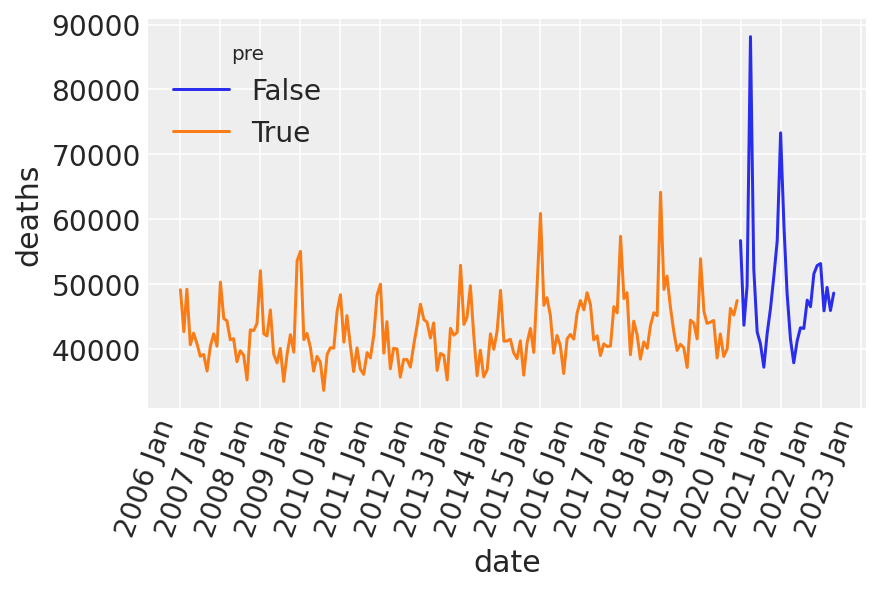

In [7]:
ax = sns.lineplot(data=df, x="date", y="deaths", hue="pre")
format_x_axis(ax)

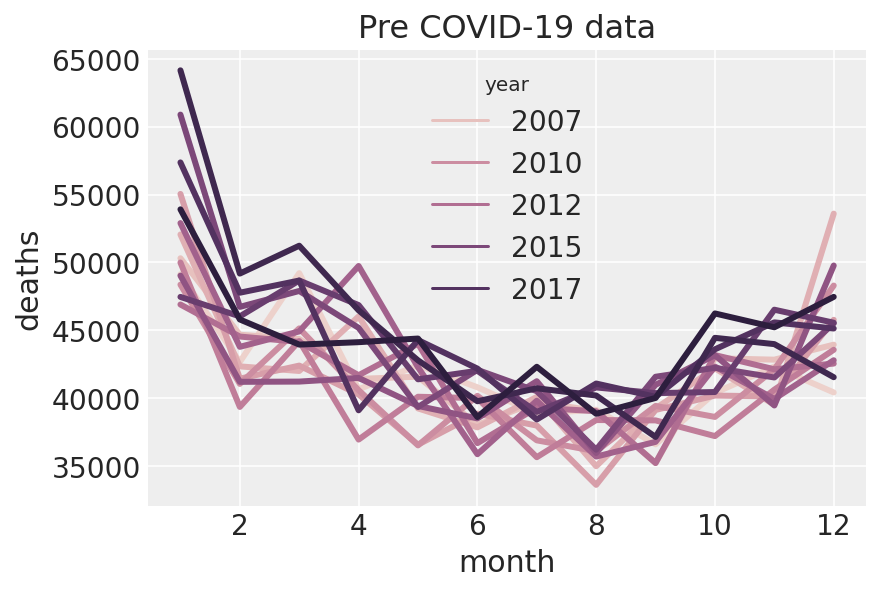

In [8]:
ax = sns.lineplot(data=pre, x="month", y="deaths", hue="year", lw=3)
ax.set(title="Pre COVID-19 data");

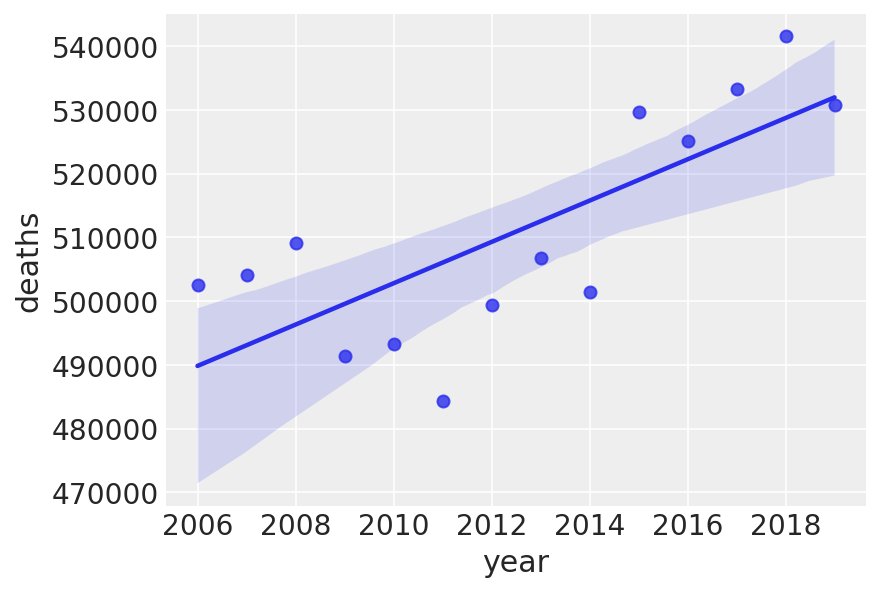

In [9]:
annual_deaths = pd.DataFrame(pre.groupby("year")["deaths"].sum()).reset_index()
sns.regplot(x="year", y="deaths", data=annual_deaths);

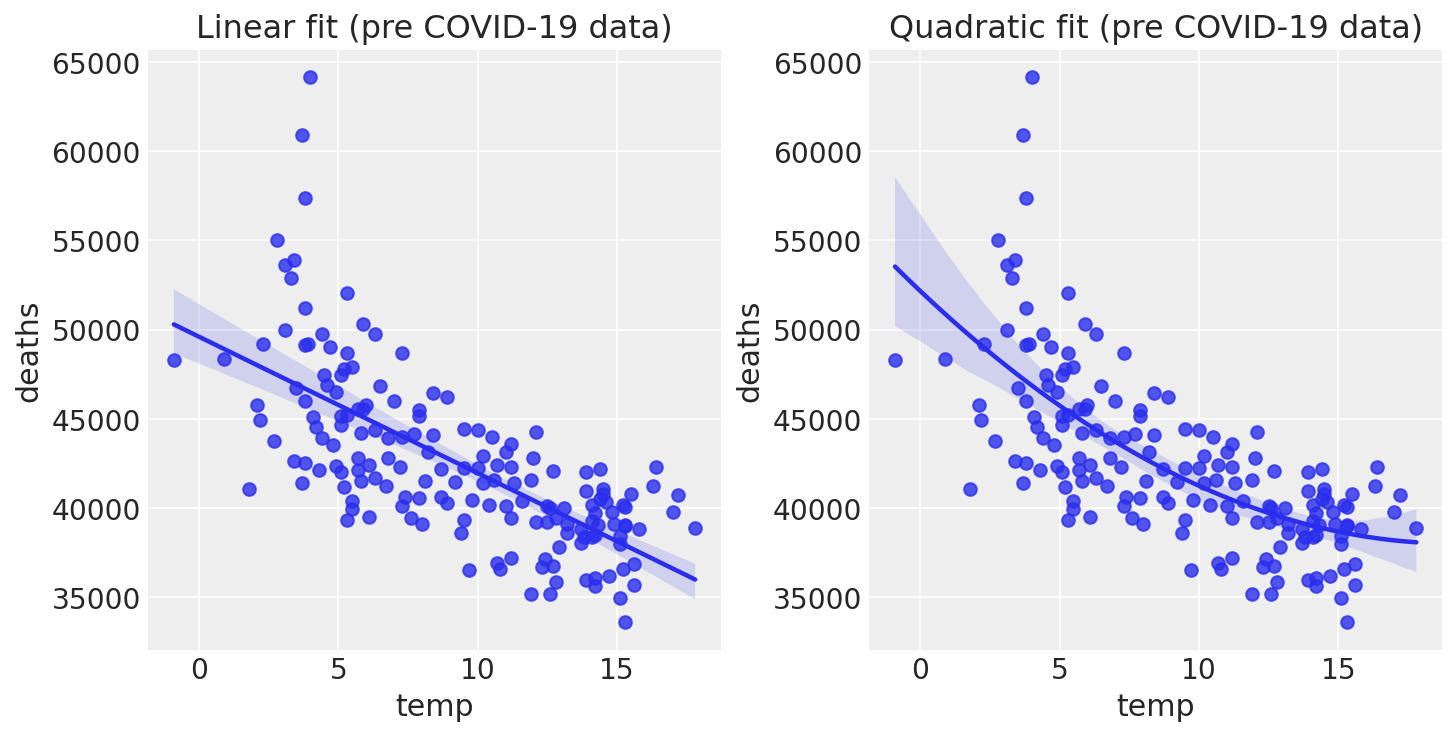

In [12]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=1, ax=ax[0])
ax[0].set(title="Linear fit (pre COVID-19 data)")
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=2, ax=ax[1])
ax[1].set(title="Quadratic fit (pre COVID-19 data)");

In [13]:
# NOTE: results are returned from higher to lower polynomial powers
slope, intercept = np.polyfit(pre["temp"], pre["deaths"], 1)
print(f"{slope:.0f} deaths/degree")

-764 deaths/degree


## Modelling

In [14]:
with pm.Model(coords={"month": month_strings}) as model:

    # observed predictors and outcome
    month = pm.MutableData("month", pre["month"].to_numpy(), dims="t")
    time = pm.MutableData("time", pre["t"].to_numpy(), dims="t")
    temp = pm.MutableData("temp", pre["temp"].to_numpy(), dims="t")
    deaths = pm.MutableData("deaths", pre["deaths"].to_numpy(), dims="t")

    # priors
    intercept = pm.Normal("intercept", 40_000, 10_000)
    month_mu = ZeroSumNormal("month mu", sigma=3000, dims="month")
    linear_trend = pm.TruncatedNormal("linear trend", 0, 50, lower=0)
    temp_coeff = pm.Normal("temp coeff", 0, 200)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) + month_mu[month - 1] + (temp_coeff * temp),
        dims="t",
    )
    sigma = pm.HalfNormal("sigma", 2_000)
    # likelihood
    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=deaths, dims="t")

In [18]:
#pm.model_to_graphviz(model)

## Prior predictive check

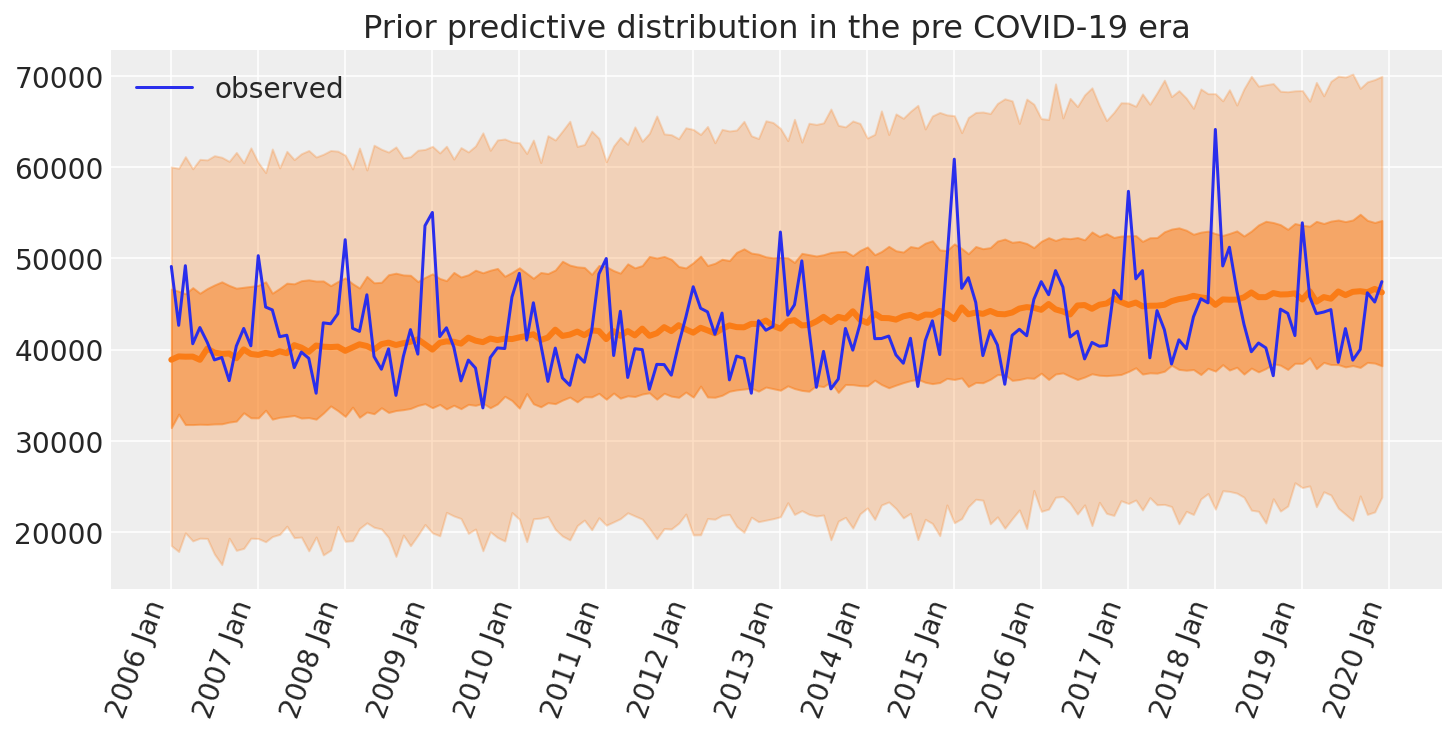

In [19]:
with model:
    idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)


fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(pre.index, pre["deaths"], label="observed")
ax.set(title="Prior predictive distribution in the pre COVID-19 era")
plt.legend();

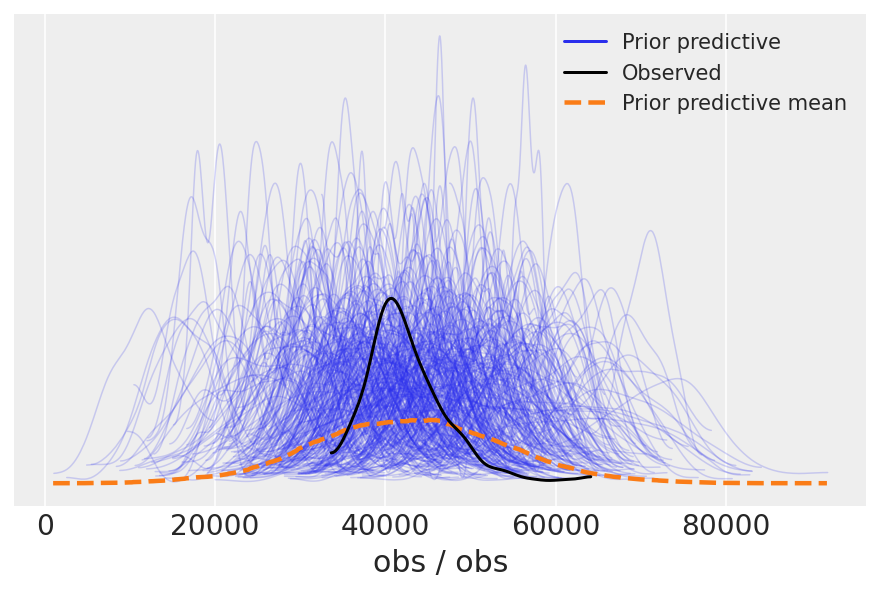

In [20]:
az.plot_ppc(idata, group="prior");


## Inference

In [21]:
#Draw samples for the posterior distribution, and remember we are doing this for the pre COVID-19 data only.
with model:
    idata.extend(pm.sample(random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, month mu_raw, linear trend, temp coeff, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


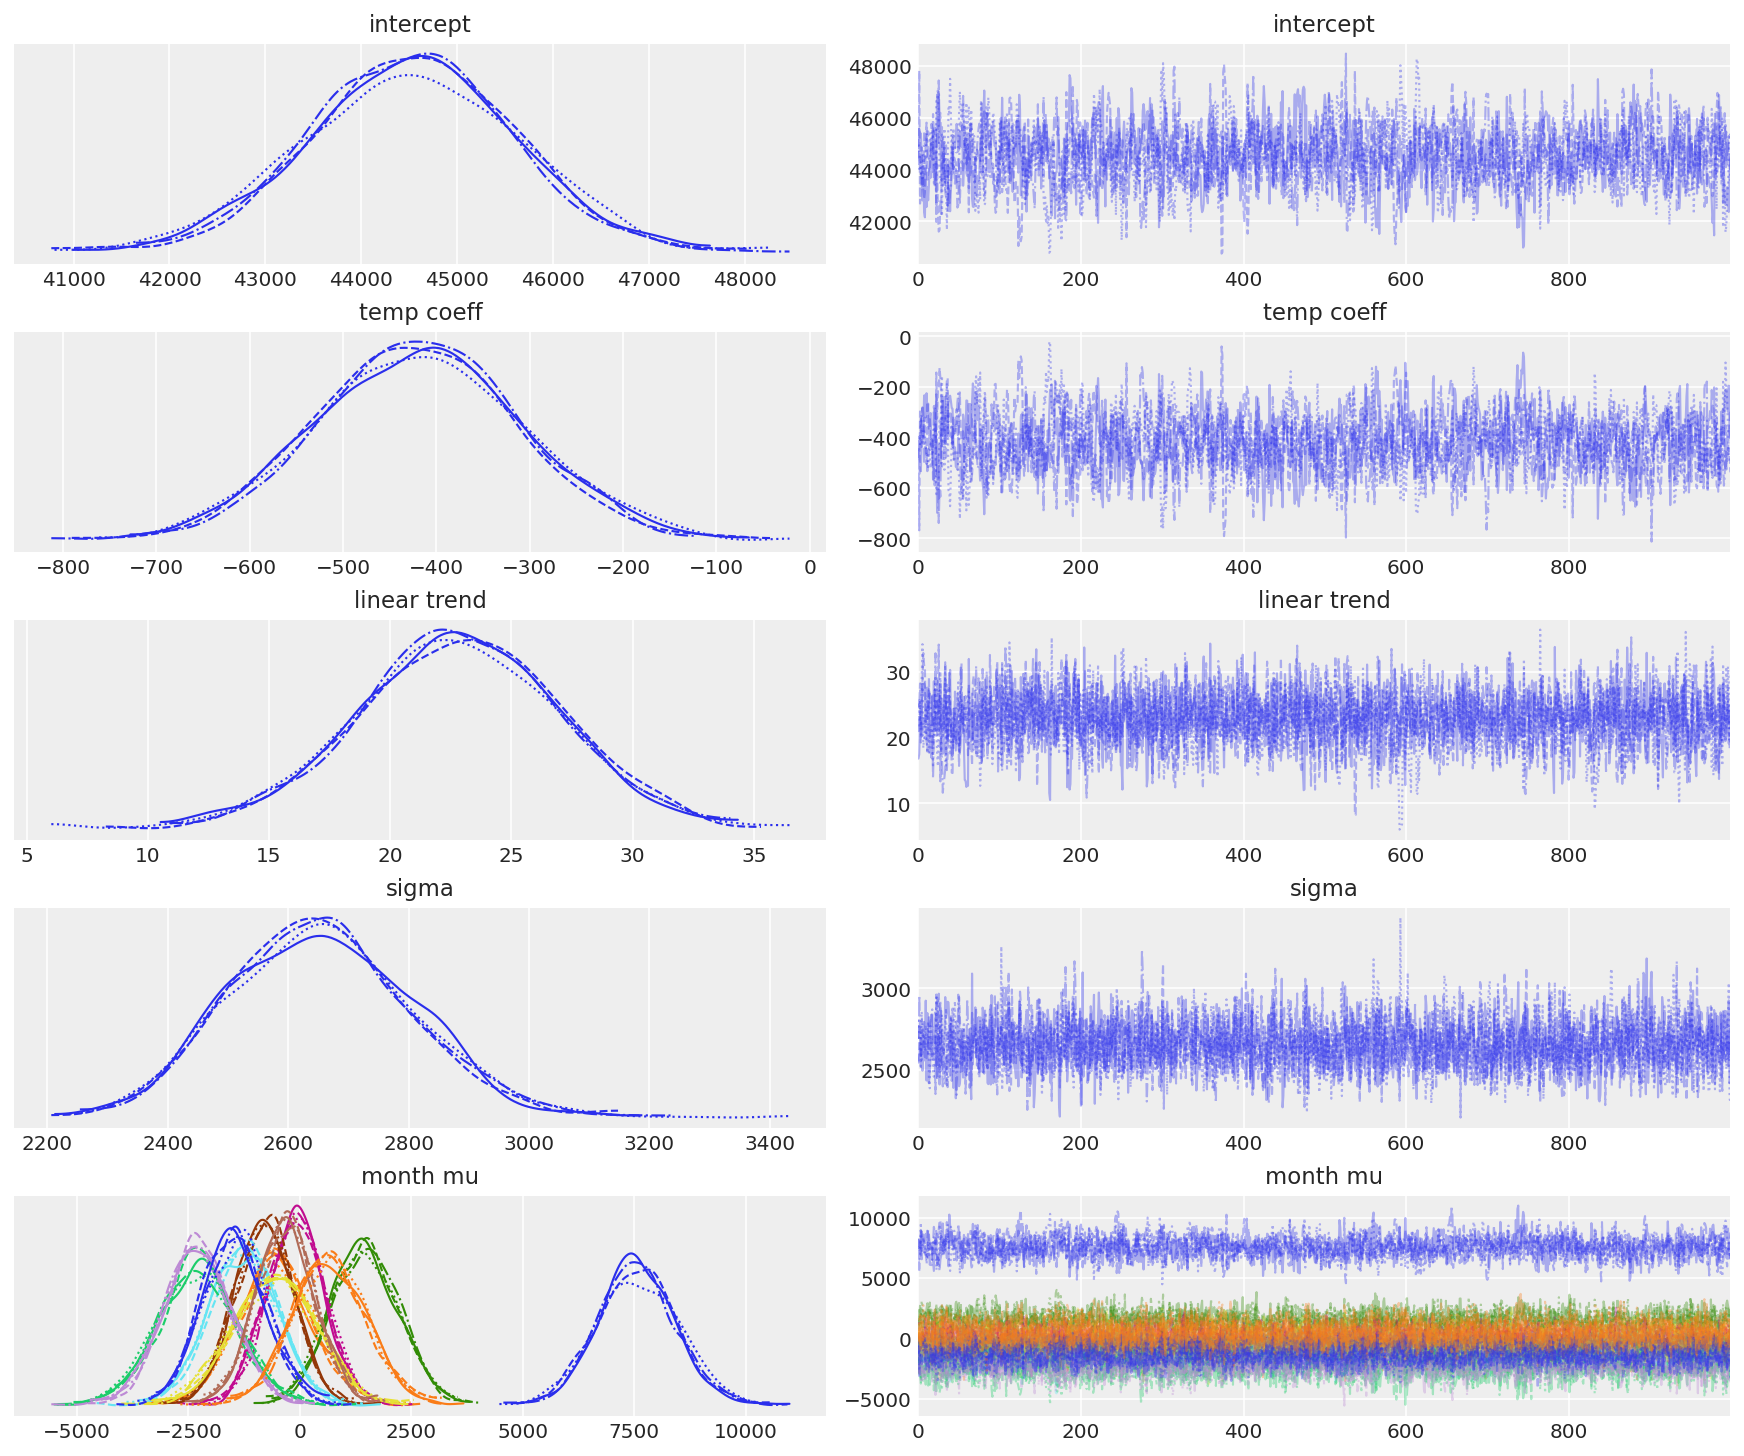

In [22]:
az.plot_trace(idata, var_names=["~mu", "~month mu_raw"]);

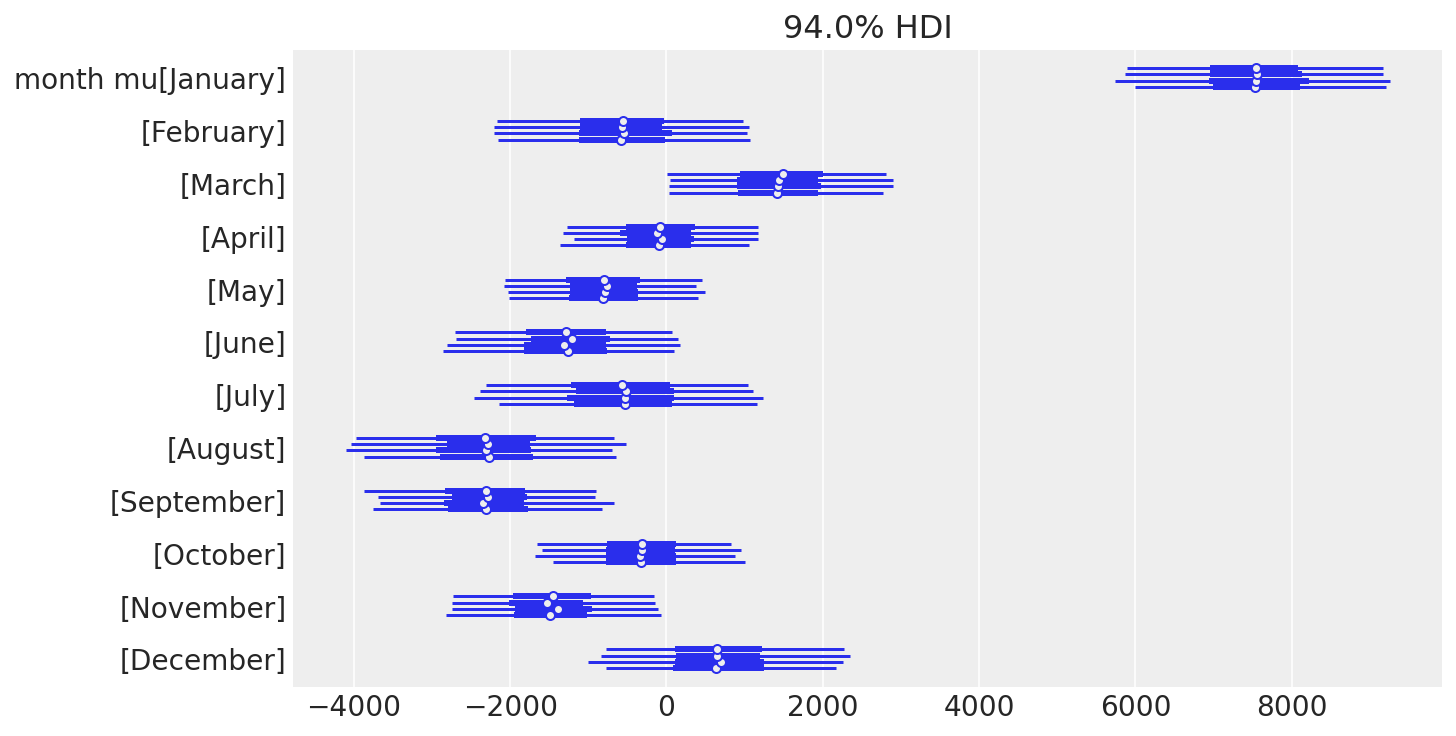

In [23]:
az.plot_forest(idata.posterior, var_names="month mu", figsize=figsize);


## Posterior predictive check


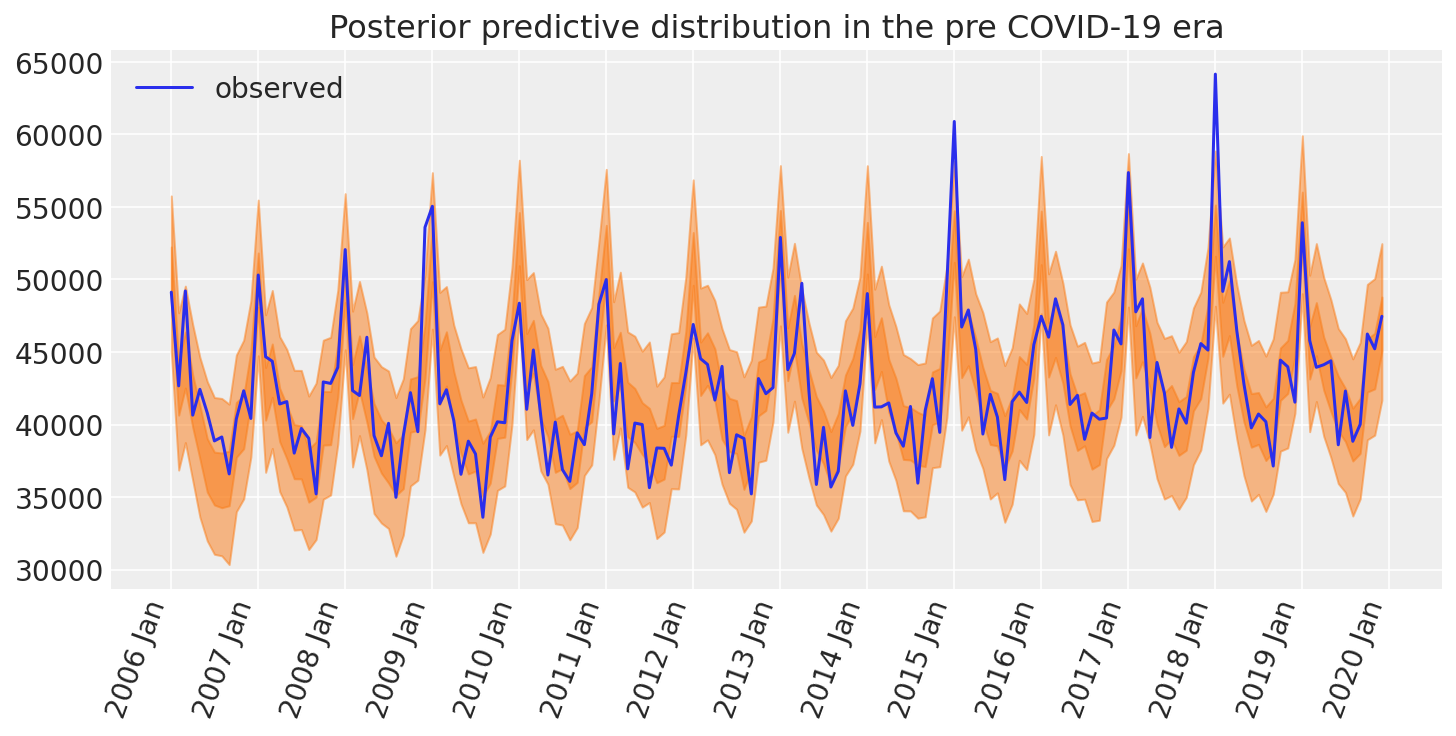

In [24]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))


fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(pre.index, pre["deaths"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre COVID-19 era")
plt.legend();

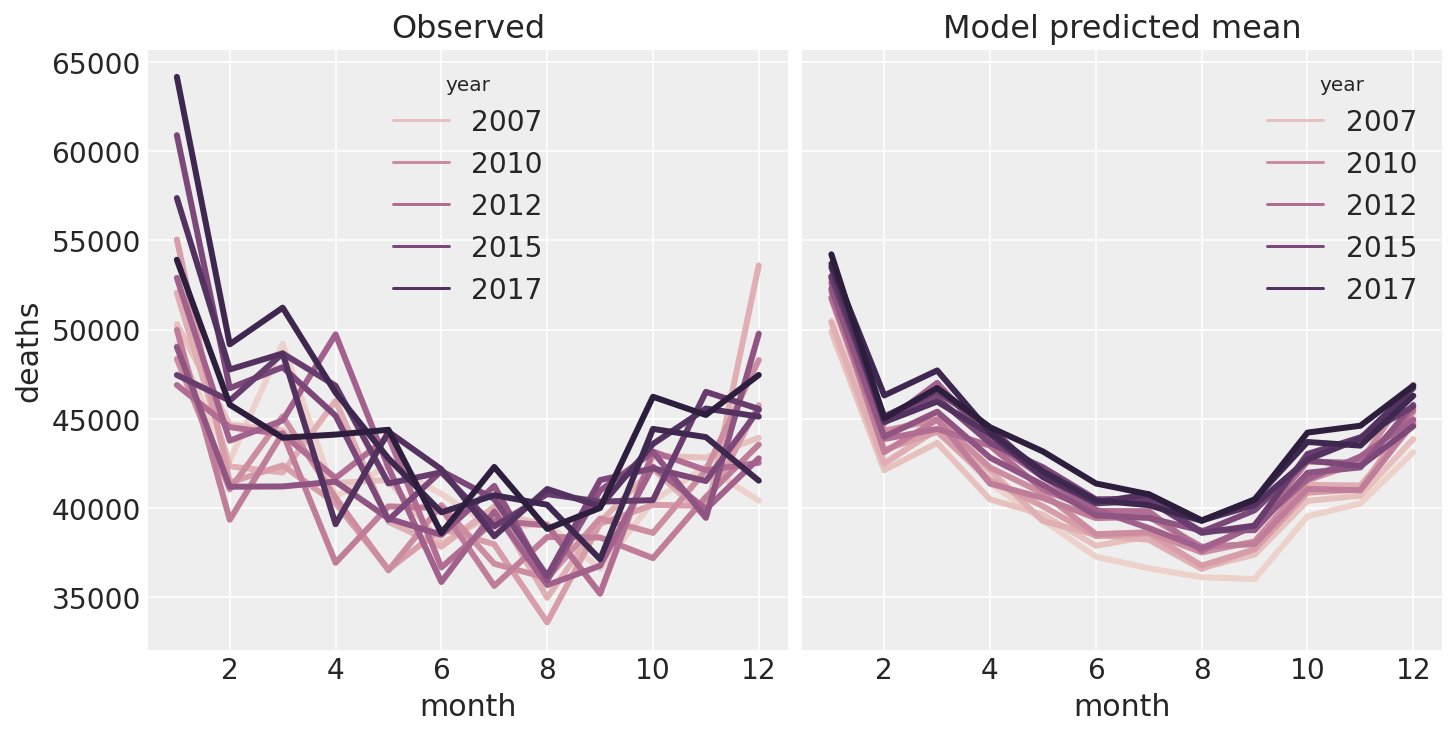

In [25]:
temp = idata.posterior["mu"].mean(dim=["chain", "draw"]).to_dataframe()
pre = pre.assign(deaths_predicted=temp["mu"].values)

fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)
sns.lineplot(data=pre, x="month", y="deaths", hue="year", ax=ax[0], lw=3)
ax[0].set(title="Observed")
sns.lineplot(data=pre, x="month", y="deaths_predicted", hue="year", ax=ax[1], lw=3)
ax[1].set(title="Model predicted mean");

# Counterfactual inference


In [26]:
with model:
    pm.set_data(
        {
            "month": post["month"].to_numpy(),
            "time": post["t"].to_numpy(),
            "temp": post["temp"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=RANDOM_SEED
    )

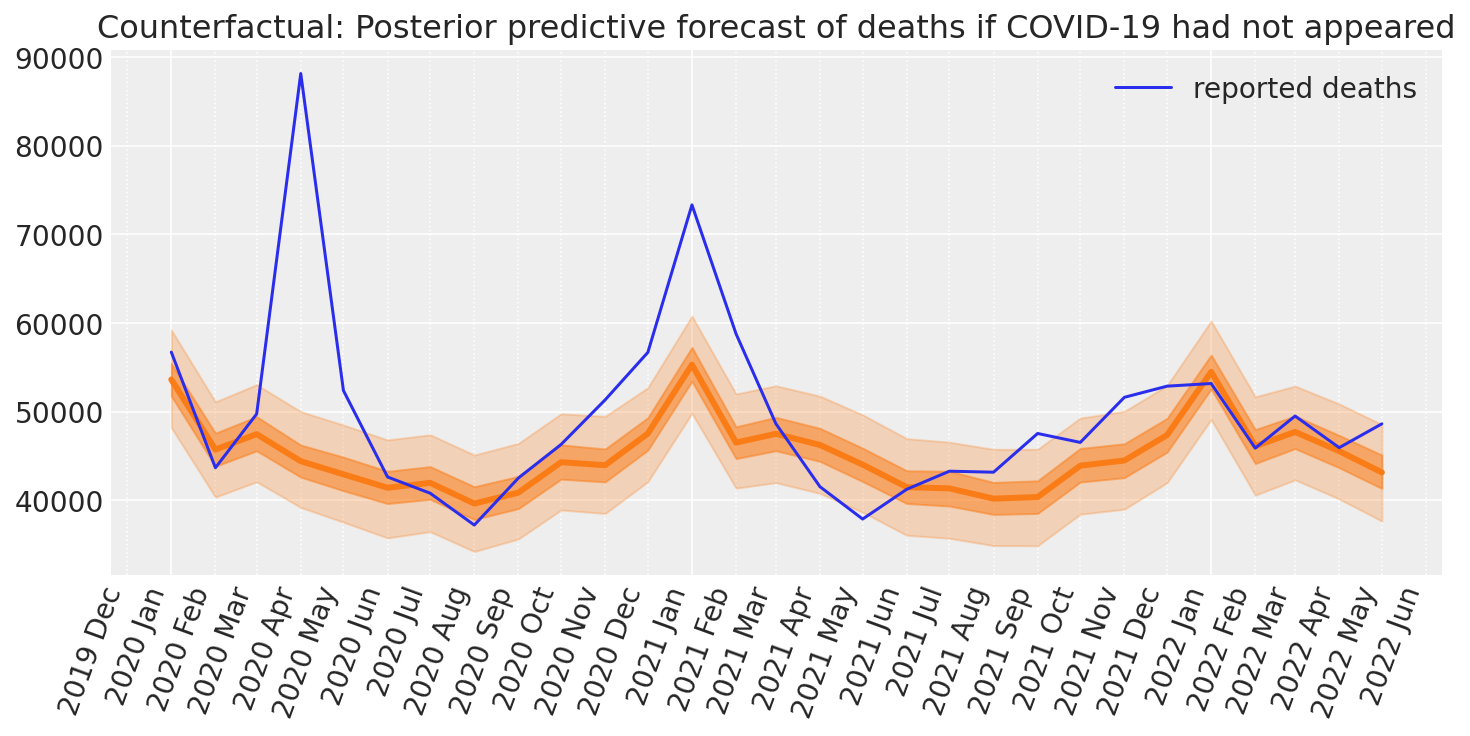

In [27]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=True)
ax.plot(post.index, post["deaths"], label="reported deaths")
ax.set(title="Counterfactual: Posterior predictive forecast of deaths if COVID-19 had not appeared")
plt.legend();

In [28]:
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(post["deaths"].to_numpy(), dims=["t"])

# do the calculation by taking the difference
excess_deaths = deaths - counterfactual.posterior_predictive["obs"]

In [29]:
# calculate the cumulative excess deaths
cumsum = excess_deaths.cumsum(dim="t")

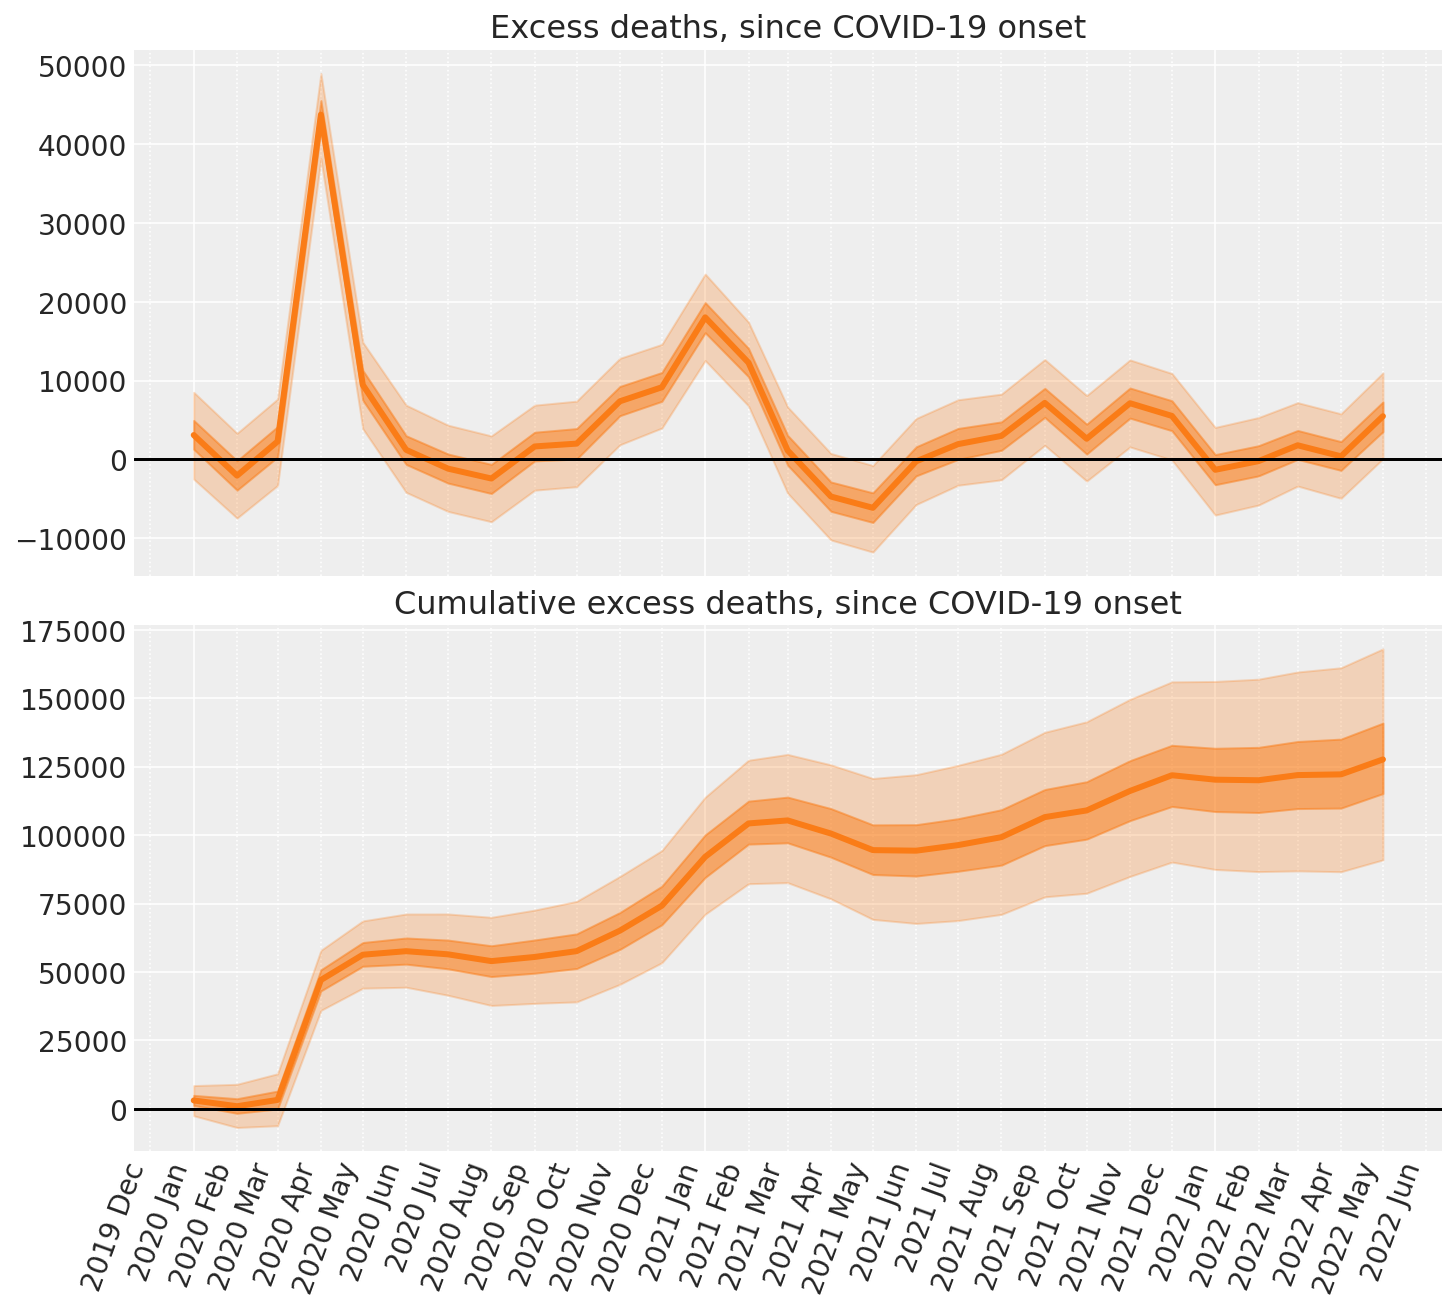

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess deaths
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, excess_deaths.transpose(..., "t"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Excess deaths, since COVID-19 onset")

# Plot the cumulative excess deaths
plot_xY(post.index, cumsum.transpose(..., "t"), ax[1])
format_x_axis(ax[1], minor=True)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative excess deaths, since COVID-19 onset");